# Класифікація тексту за допомогою моделей Bag-of-words та TF-IDF

![](https://i.imgur.com/hlEQ5X8.png)

> _"Обробка природної мови (NLP) - це підгалузь лінгвістики, комп'ютерних наук та штучного інтелекту, що стосується взаємодії між комп'ютерами та людською мовою, зокрема, як програмувати комп'ютери для обробки та аналізу великих обсягів даних природної мови."_ - Вікіпедія

> _**Мішок слів (Bag of Words)**: Модель мішка слів (BOW) - це представлення, яке перетворює довільний текст у вектори фіксованої довжини, підраховуючи, скільки разів кожне слово з'являється._

План:

1. Завантажити та дослідити реальний набір даних
2. Застосувати техніки попередньої обробки тексту
3. Реалізувати модель мішка слів
4. Навчити моделі машинного навчання для класифікації тексту
5. Зробити прогнози на тренуванні і тесті, проаналізувати результати.

Набір даних: https://www.kaggle.com/c/quora-insincere-questions-classification

Працюємо тільки з `train.csv`.

Наша задача - виявити, який контент є токсичний для того аби поліпшити онлайн спілкування на платформі Quora.

## Завантаження та дослідження даних

In [3]:
import pandas as pd

In [4]:
train_fname = 'quora_train.csv.zip'
raw_df = pd.read_csv(train_fname)

In [5]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Дослілимо дані, які не є токсичними.

In [6]:
sincere_df = raw_df[raw_df.target == 0]

In [7]:
sincere_df.question_text.values[:10]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
       'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something g

А тепер ті, які є токсичними.

In [8]:
insincere_df = raw_df[raw_df.target == 1]

In [9]:
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

Який баланс класів в наборі даних?

In [10]:
raw_df.target.value_counts(normalize=True)

target
0    0.93813
1    0.06187
Name: proportion, dtype: float64

Бачимо, що токсичних у нас менше.

### Створити робочий зразок

In [11]:
SHORTEN = True

In [12]:
if SHORTEN:
    SAMPLE_SIZE = 100000
    raw_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
else:
    SAMPLE_SIZE = len(raw_df)

## Попередня обробка тексту

1. Розуміння моделі "мішок слів" (bag of words model)
2. Розуміння моделі TF-IDF (term frequency - inverted document frequency)
2. Токенізація (Tokenization)
3. Видалення стоп-слів (Stop word removal)
4. Стемінг (Stemming)

### Інтуїція моделі векторизації тексту Bag of Words (BoW)

1. **Створення словника слів**: Спочатку ми створюємо список усіх слів, які з'являються у всіх текстових документах. Цей список можна вважати "словником" або "всесвітом" усіх слів, що зустрічаються в наборі даних.

2. **Перетворення документа у вектор**: Кожен документ перетворюється на вектор, де кожен елемент відповідає кількості появ певного слова з цього словника в документі. Якщо слово зустрічається у документі 3 рази, його відповідне значення буде 3, якщо жодного разу — 0.

![](https://vitalflux.com/wp-content/uploads/2021/08/Bag-of-words-technique-to-convert-to-numerical-feature-vector-png.png)

Цей метод ефективний, якщо ми просто хочемо підрахувати слова, але він має низку обмежень, які можуть впливати на результати аналізу тексту.

### Основні проблеми з методом "Мішок слів" (BoW)

1. **Розмірність векторів**: Якщо у вас є великий набір даних з багатьма документами, словник буде містити величезну кількість унікальних слів. Це призводить до дуже великих векторів, які важко обробляти та зберігати. Ця проблема відома як "прокляття розмірності".

2. **Часті, але незначущі слова (стоп-слова)**: Деякі слова (такі як "і", "але", "це") з'являються дуже часто у всіх документах, але не мають великого сенсу для класифікації чи аналізу. У BoW ці слова можуть мати високу вагу, навіть якщо вони не несуть смислового навантаження.

3. **Рідкісні, але важливі слова**: Навпаки, деякі слова можуть з'являтися лише в одному документі, але бути важливими для класифікації або розуміння змісту. Наприклад, терміни, специфічні для певної теми або документа. У BoW ці слова можуть мати таку ж вагу, як і менш важливі слова, що знижує якість аналізу.

4. **Множинні форми слів**: Одне слово може мати багато різних форм (наприклад, "go", "gone", "going" або "bird" і "birds"). У BoW всі ці форми будуть розглядатися як різні слова, що збільшує розмірність і ускладнює аналіз. Це робить модель менш стійкою до різних форм одного і того ж слова.


Розглянемо приклади.

In [13]:
q0 = sincere_df.question_text.values[1]

In [14]:
q0

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [15]:
q1 = raw_df[raw_df.target == 1].question_text.values[0]

In [16]:
q1

'Is Yahoo owned by the Jews?'

### Токенізація

Токенізація – це процес розбиття тексту на менші одиниці, звані токенами. Токени можуть бути окремими словами, фразами або навіть символами.
Мета токенізації – перетворити текст у структуру, яка зручна для подальшого аналізу і обробки моделями NLP. Наприклад, речення "NLP is fun!" може бути токенізовано на ["NLP", "is", "fun", "!"].
Токенізація дозволяє враховувати кожне слово або символ як окрему одиницю для аналізу.

Будемо тут використовувати бібліотеку nltk.

Бібліотека **Natural Language Toolkit (NLTK)** є однією з найпопулярніших бібліотек для обробки природної мови на Python. Вона пропонує широкий набір інструментів і ресурсів для дослідження і побудови NLP моделей.
Посилання: https://www.nltk.org/

Основні можливості бібліотеки NLTK

1. **Токенізація**
 - Інструменти для розбиття тексту на речення або слова (токени). Це включає базові методи токенізації на основі пробілів і пунктуації, а також більш просунуті методи для підтримки різних мов.

2. **Стемінг і лематизація**
   - Підтримка різних алгоритмів для стемінгу (наприклад, алгоритм Портера, алгоритм Ланкастера) і лематизації (наприклад, використання словників WordNet). Ці інструменти допомагають нормалізувати слова до їх основних або кореневих форм.

3. **Видалення стоп-слів**
   - Вбудований список стоп-слів для різних мов та інструменти для їх видалення з тексту, щоб зосередитися на більш значущих термінах.

4. **Частотний аналіз**
   - Інструменти для підрахунку частоти слів та n-грам (послідовностей з n слів) у тексті, що є корисним для аналізу тексту і виявлення ключових слів або фраз.

5. **Частина мови (POS) тегінг**
   - Можливість автоматичного визначення частин мови (іменник, дієслово, прикметник тощо) для кожного слова в тексті, використовуючи вбудовані таггери (наприклад, Perceptron Tagger, Maximum Entropy Tagger).

6. **Визначення іменованих сутностей (Named Entity Recognition, NER)**
   - Інструменти для автоматичного виявлення іменованих сутностей у тексті, таких як особи, організації, місця та інші категорії.

7. **Моделювання граматичної структури речення**
   - Інструменти для парсингу речень і побудови синтаксичних дерев, що показують граматичну структуру речення.

8. **Обробка та аналіз корпусів тексту**
   - Вбудовані корпуси тексту для навчання і тестування моделей NLP, такі як "Brown Corpus", "Reuters Corpus", "Movie Reviews", а також інтерфейси до зовнішніх ресурсів, як-от WordNet.

9. **Алгоритми машинного навчання для NLP**
   - Можливість використовувати різні алгоритми машинного навчання (наприклад, наївний Байєс, дерева рішень) для вирішення NLP завдань, таких як класифікація тексту або аналіз настроїв.

10. **Побудова n-грам моделей**
    - Інструменти для створення моделей на основі n-грам, що використовуються для прогнозування наступних слів або аналізу послідовностей у тексті.

11. **Візуалізація даних**
    - Інструменти для створення графіків частотності слів, дерев синтаксичного аналізу та інших візуалізацій для більш глибокого розуміння текстових даних.

12. **Інтерфейси для інших бібліотек**
    - Інтеграція з іншими бібліотеками та ресурсами, такими як WordNet, TextBlob та інші інструменти для NLP.

Переваги використання NLTK:

- **Легкість у використанні:** NLTK має простий і зручний інтерфейс для новачків у NLP, а також добре документований API.
- **Велика спільнота:** NLTK має велику спільноту користувачів і розробників, що сприяє швидкому вирішенню питань і обміну досвідом.
- **Освітній ресурс:** Завдяки багатій документації та численним прикладам, NLTK є популярним вибором для навчання обробки природної мови в університетах та на онлайн-курсах.


In [17]:
'NLP is fun!'.replace('!', '').split()

['NLP', 'is', 'fun']

In [18]:
import nltk

In [19]:
from nltk.tokenize import word_tokenize

Токенізатор речень Punkt Sentence розділяє текст на список речень, використовуючи unsupervized алгоритм для побудови моделі для слів-абревіатур, словосполучень і слів, що починають речення. Перед використанням його потрібно навчити на великій колекції відкритих текстів цільовою мовою.


In [20]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/dmytro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dmytro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Punkt більш розумний за звичайне розбиття слів за пробілами.

In [21]:
from nltk.tokenize import PunktSentenceTokenizer
text = '''
Punkt knows that the periods in Mr. Smith and Johann S. Bach
do not mark sentence boundaries.  And sometimes sentences
can start with non-capitalized words.  i is a good variable
name.
'''
sent_detector = PunktSentenceTokenizer()
print('\n-----\n'.join(sent_detector.tokenize(text.strip())))

Punkt knows that the periods in Mr.
-----
Smith and Johann S. Bach
do not mark sentence boundaries.
-----
And sometimes sentences
can start with non-capitalized words.
-----
i is a good variable
name.


Але ми будемо докенізувати до слова, не до речення.

Наше речення до токенізації.

In [22]:
q0

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

Після.

In [23]:
word_tokenize(q0)

['Do',
 'you',
 'have',
 'an',
 'adopted',
 'dog',
 ',',
 'how',
 'would',
 'you',
 'encourage',
 'people',
 'to',
 'adopt',
 'and',
 'not',
 'shop',
 '?']

Класно те, що символи пунктуації відділяються від слова!

In [24]:
word_tokenize(' this is (something) with, a lot of, punctuation;')

['this',
 'is',
 '(',
 'something',
 ')',
 'with',
 ',',
 'a',
 'lot',
 'of',
 ',',
 'punctuation',
 ';']

In [25]:
q1

'Is Yahoo owned by the Jews?'

In [26]:
word_tokenize(q1)

['Is', 'Yahoo', 'owned', 'by', 'the', 'Jews', '?']

In [27]:
q0_tok = word_tokenize(q0)
q1_tok = word_tokenize(q1)

### Видалення стоп-слів

**Стоп-слова** — це загальновживані слова, які не мають суттєвого смислового навантаження і часто не несуть важливої інформації для розуміння змісту тексту. Приклади стоп-слів: "і", "або", "але", "що", "якщо", "на", "у", "з", "до", "від", "я", "він", "вона" тощо.

У задачах обробки природної мови (NLP) стоп-слова зазвичай видаляються з тексту, щоб зменшити розмір даних і підвищити ефективність моделей. Видалення стоп-слів дозволяє зосередитися на більш важливих, змістовних термінах, що допомагають краще розпізнавати патерни в тексті для різних NLP завдань, таких як класифікація тексту, аналіз настроїв або пошук інформації.



In [28]:
q1_tok

['Is', 'Yahoo', 'owned', 'by', 'the', 'Jews', '?']

In [29]:
from nltk.corpus import stopwords

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmytro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
english_stopwords = stopwords.words('english')

Переглянемо список стоп-слів.

In [32]:
", ".join(english_stopwords)

"a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to, too, under, until, up, 

До слова, українські стопслова можна завантажити тут - https://github.com/skupriienko/Ukrainian-Stopwords

Функція для видалення стоп-слів.


In [33]:
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

In [34]:
q0_tok

['Do',
 'you',
 'have',
 'an',
 'adopted',
 'dog',
 ',',
 'how',
 'would',
 'you',
 'encourage',
 'people',
 'to',
 'adopt',
 'and',
 'not',
 'shop',
 '?']

In [35]:
q0_stp = remove_stopwords(q0_tok)

In [36]:
q0_stp

['adopted', 'dog', ',', 'would', 'encourage', 'people', 'adopt', 'shop', '?']

In [37]:
q1_stp = remove_stopwords(q1_tok)

In [38]:
q1_tok

['Is', 'Yahoo', 'owned', 'by', 'the', 'Jews', '?']

In [39]:
q1_stp

['Yahoo', 'owned', 'Jews', '?']

### Стемінг
**Стемінг** – це процес скорочення слова до його кореня або основної форми шляхом відкидання суфіксів чи префіксів. Наприклад, слова "running", "runner", "ran" скорочуються до "run". Стемінг є менш точним методом, оскільки він використовує евристичні правила для скорочення слів, що може призвести до отримання неіснуючих слів (наприклад, "univers" від "universe" та "university").

В нашому випадку ми хочемо різні форми слова привести до одної:

*   "go", "gone", "going" -> "go"  
*   "birds", "bird" -> "bird"




In [40]:
from nltk.stem.snowball import SnowballStemmer

In [41]:
stemmer = SnowballStemmer(language='english')

In [42]:
stemmer.stem('going')

'go'

In [43]:
stemmer.stem('supposedly')

'suppos'

In [44]:
q0_stm = [stemmer.stem(word) for word in q0_stp]

In [45]:
q0_stp

['adopted', 'dog', ',', 'would', 'encourage', 'people', 'adopt', 'shop', '?']

In [46]:
q0_stm

['adopt', 'dog', ',', 'would', 'encourag', 'peopl', 'adopt', 'shop', '?']

In [47]:
q1_stm = [stemmer.stem(word) for word in q1_stp]

In [48]:
q1_stp

['Yahoo', 'owned', 'Jews', '?']

In [49]:
q1_stm

['yahoo', 'own', 'jew', '?']

### Лематизація
Існує альтернатива до стемінгу - лематизація.

**Лематизація** – це процес перетворення слова у його базову або лемматичну форму, зважаючи на його морфологію та контекст у реченні. Наприклад, для слова "better" лематизація визначить основну форму як "good". Лематизація є більш формальною та точною, ніж стемінг, оскільки враховує граматичні правила та використання словника.

Який спосіб нормалізації слів використовувати треба вирішувати для кожної задачі окремо враховуючи її особливості і також експериментуючи і аналізуючи помилки.

Ще приклад лемматизації:

  "love" -> "love"  
  "loving" -> "love"  
  "lovable" -> "love"  

## Реалізація Мішка Слів
Як ми самостійно можемо реалізувати векторизацію з мішком слів:

1. Створити словник за допомогою Count Vectorizer
2. Перетворити текст на вектори за допомогою Count Vectorizer
3. Налаштувати попередню обробку тексту в Count Vectorizer

### Створення словника

In [50]:
raw_df.question_text.values

array(['What is the most effective classroom management skill/technique to create a good learning environment?',
       'Can I study abroad after 10th class from Bangladesh?',
       'How can I make friends as a college junior?', ...,
       'What are some services that will let you quickly separate parts of a video at the five minute and ten minute mark into two separate videos?',
       'What credit card processors do online marketplaces use?',
       'On which number system does a computer work?'], dtype=object)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
raw_vect = CountVectorizer()

In [53]:
raw_vect_fit = raw_vect.fit(raw_df.question_text)

In [54]:
raw_vect.get_feature_names_out()[10000:10010]

array(['cleaved', 'cleaveland', 'cleaver', 'cleen', 'clefs', 'cleft',
       'clemency', 'clemente', 'clementines', 'clemmensen'], dtype=object)

In [55]:
raw_vect.get_feature_names_out()[:10]

array(['00', '000', '0000', '00000001', '0005', '000501', '000czk', '001',
       '003', '003a'], dtype=object)

### Перетворення документів у вектори

In [56]:
%%time
vectors = raw_vect.transform(raw_df.question_text)

CPU times: user 463 ms, sys: 5.1 ms, total: 468 ms
Wall time: 467 ms


In [57]:
vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1155416 stored elements and shape (100000, 51543)>

In [58]:
vectors.shape

(100000, 51543)

In [59]:
raw_df.question_text.values[0]

'What is the most effective classroom management skill/technique to create a good learning environment?'

In [60]:
vectors[0].toarray()[0][100:110]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
# vectors.toarray()

### Налаштування параметрів Count Vectorizer

In [62]:
stemmer = SnowballStemmer(language='english')

In [63]:
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [64]:
tokenize('What is the really (dealing) here?')

['what', 'is', 'the', 'realli', '(', 'deal', ')', 'here', '?']

In [65]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [66]:
%%time
vectorizer.fit(raw_df.question_text)

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 8.18 s, sys: 14.2 ms, total: 8.19 s
Wall time: 8.2 s


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x342bb7880>)

In [67]:
len(vectorizer.vocabulary_)

1000

In [68]:
vectorizer.get_feature_names_out()[:100]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '4', '5', '6', '7', '8', ':', '?', '[', ']', '``', 'abl',
       'abroad', 'abus', 'accept', 'access', 'accomplish', 'accord',
       'account', 'achiev', 'act', 'action', 'activ', 'actor', 'actual',
       'ad', 'add', 'address', 'admiss', 'adult', 'advanc', 'advantag',
       'advic', 'affect', 'africa', 'african', 'age', 'agre', 'air',
       'allow', 'almost', 'alon', 'alreadi', 'also', 'altern', 'alway',
       'amazon', 'america', 'american', 'amount', 'analysi', 'android',
       'ani', 'anim', 'anoth', 'answer', 'anxieti', 'anyon', 'anyth',
       'apart', 'app', 'appear', 'appl', 'appli', 'applic', 'approach',
       'arab', 'area', 'armi', 'around', 'art', 'asian', 'ask', 'associ',
       'atheist', 'attack', 'attend'], dtype=object)

In [69]:
%%time
inputs = vectorizer.transform(raw_df.question_text)

CPU times: user 8.06 s, sys: 8.27 ms, total: 8.07 s
Wall time: 8.07 s


In [70]:
inputs.shape

(100000, 1000)

In [71]:
inputs[:10]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 51 stored elements and shape (10, 1000)>

In [72]:
raw_df.question_text.values[0]

'What is the most effective classroom management skill/technique to create a good learning environment?'

In [73]:
inputs[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Для трансформації тестового набору ми могли б запустити наступний код:

In [74]:
%%time
# test_inputs = vectorizer.transform(test_df.question_text)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.15 μs


## Навчання ML-моделі для класифікації тексту

План:

- Створити навчальний та валідаційний набори
- Навчити модель логістичної регресії
- Зробити прогнози на навчальних, валідаційних та тестових даних

### Розділення на навчальний та валідаційний набори

In [75]:
inputs.shape

(100000, 1000)

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, raw_df.target,
                                                                        test_size=0.3, random_state=42)

In [78]:
train_inputs.shape

(70000, 1000)

In [79]:
train_targets.shape

(70000,)

In [80]:
val_inputs.shape

(30000, 1000)

In [81]:
val_targets.shape

(30000,)

### Навчання моделі логістичної регресії

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
MAX_ITER = 1000

In [84]:
model = LogisticRegression(max_iter=MAX_ITER, solver='sag')

In [85]:
%%time
model.fit(train_inputs, train_targets)

CPU times: user 4.57 s, sys: 4.73 ms, total: 4.57 s
Wall time: 4.57 s


/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='sag')

### Робіть прогнози за допомогою моделі

In [86]:
train_preds = model.predict(train_inputs)

In [87]:
train_targets

133883     0
343925     0
1190558    0
317078     0
355610     0
          ..
262505     0
879467     0
411614     0
859707     0
683832     0
Name: target, Length: 70000, dtype: int64

In [88]:
train_preds

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
pd.Series(train_preds).value_counts()

0    67957
1     2043
Name: count, dtype: int64

In [90]:
pd.Series(train_targets).value_counts()

target
0    65784
1     4216
Name: count, dtype: int64

In [91]:
from sklearn.metrics import accuracy_score, f1_score

In [92]:
accuracy_score(train_targets, train_preds)

0.9504428571428571

In [93]:
f1_score(train_targets, train_preds)

0.4457581083240134

Порівняємо з примітивною моделлю, яка каже про кожну фразу, що вона є екологічною (target=0):



In [94]:
import numpy as np

In [95]:
accuracy_score(train_targets, np.zeros(len(train_targets)))

0.9397714285714286

In [96]:
f1_score(train_targets, np.zeros(len(train_targets)))

0.0

### Як отримати передбачення на нових даних?
Все просто! Трансформуємо дані з натренованим векторизатором і передаємо в модель.

In [97]:
model.predict(vectorizer.transform(sincere_df.question_text.values[:10]))

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [98]:
model.predict_proba(vectorizer.transform(sincere_df.question_text.values[:10]))[:,1].round(2)

array([0.07, 0.1 , 0.  , 0.02, 0.03, 0.04, 0.91, 0.04, 0.01, 0.02])

In [99]:
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

In [100]:
insincere_df.target.values[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [101]:
model.predict(vectorizer.transform(insincere_df.question_text.values[:10]))

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0])

## Аналіз помилок

In [102]:
raw_df['prediction'] = model.predict(inputs)

In [103]:
raw_df.shape

(100000, 4)

In [104]:
from sklearn.metrics import confusion_matrix

In [105]:
confusion_matrix(raw_df.target, raw_df.prediction)

array([[92985,   977],
       [ 4091,  1947]])

Дослідимо ще як розподілені передбачення класу target=1.

In [106]:
raw_df['prediction_proba'] = model.predict_proba(inputs)[:, 1]

In [107]:
raw_df.target.value_counts()

target
0    93962
1     6038
Name: count, dtype: int64

<Axes: >

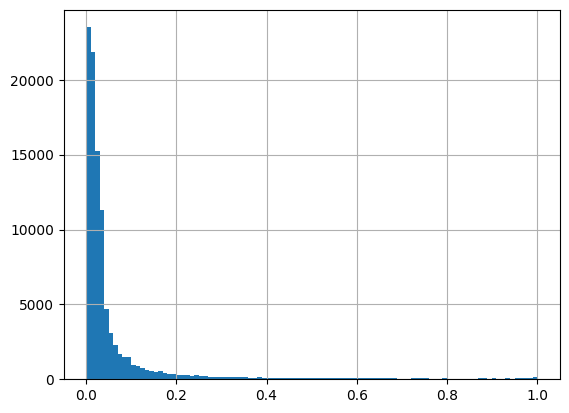

In [108]:
raw_df.prediction_proba.hist(bins=100)

Я б змістила поріг класифікації до 0.1-0.2 і це б поліпшило F1.

In [109]:
raw_df['prediction_0.2'] = raw_df.prediction_proba > 0.2

In [110]:
f1_score(raw_df.target, raw_df['prediction_0.2'])

0.5159994046733145

In [111]:
confusion_matrix(raw_df.target, raw_df['prediction_0.2'])

array([[90029,  3933],
       [ 2571,  3467]])

Можемо також дослідити окремо питання, в яких робимо false positive та false negative передбачення.

In [112]:
raw_df['error'] = raw_df.target != raw_df['prediction_0.2']

False negative результати можемо дістати наступним чином:

In [113]:
raw_df[raw_df.error & raw_df.target==1]

,qid,question_text,target,prediction,prediction_proba,prediction_0.2,error
691951,8786fa2e795d2d0e1440,Is Yahoo owned by the Jews?,1,0,0.168225,False,True
1057714,cf41b3cc824bdc767b4b,"If Macedonia is supposedly ""purely"" Greek and ...",1,0,0.027373,False,True
30882,0609338dee541a017b5f,Could the numerous acts of arms being severed ...,1,0,0.025920,False,True
908188,b1f5208e0f44556a5964,Should plus-size women wear dresses and skirts...,1,0,0.124354,False,True
933912,b704f07087d87705b434,Why do we constantly get questions from gun-gr...,1,0,0.141709,False,True
...,...,...,...,...,...,...,...
840664,a4c0771befc0fdb5204c,It is not strange that there wasn’t any attemp...,1,0,0.197600,False,True
709348,8adf3b4c5f39625a1ed1,What was the real reason for Jesus to quit the...,1,0,0.004363,False,True
596632,74db98e51a653f6927c6,Is Astrologer R K Shastri Fraud?,1,0,0.031453,False,True
938680,b7f526728f983ee04683,Why do Sikhs hate Hindus?,1,0,0.150078,False,True


Тут ще буде корисно зробити аналіз feature importance. Такі слова як `black`, `white`, `jews` скоріш за все добре контрибʼютять в передбачення, що питання - неекологічне.

In [114]:
feature_importance = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

liber      2.476651
rape       2.372791
muslim     2.289492
obama      2.228534
atheist    1.909058
             ...   
food      -1.149184
appli     -1.222990
affect    -1.251260
2017      -1.425212
?         -2.339957
Name: imp, Length: 1000, dtype: float64

In [115]:
import numpy

1/(1+np.exp(-(10)))

0.9999546021312976

In [116]:
feature_importance[:10]

liber       2.476651
rape        2.372791
muslim      2.289492
obama       2.228534
atheist     1.909058
sister      1.844765
democrat    1.834231
jew         1.829033
trump       1.800319
gay         1.789910
Name: imp, dtype: float64

Гіпотеза підтвердилась і так ви можете зрозуміти, чому ваша модель робить ті чи інші передбачення.

І навпаки ось ці слова зменшують ймовірність, що питання неекологічне/токсичне:

In [117]:
feature_importance[-10:]

situat    -1.015898
tv        -1.026722
refer     -1.043694
account   -1.051593
career    -1.104752
food      -1.149184
appli     -1.222990
affect    -1.251260
2017      -1.425212
?         -2.339957
Name: imp, dtype: float64

# TF-IDF

Ще один спосіб векторизації.

TF-IDF (Term Frequency-Inverse Document Frequency) — це спосіб визначити важливість слова в тексті, зокрема в наборі текстів (документах). Уявіть, що ви читаєте багато статей, і хочете зрозуміти, які слова є найважливішими в кожній з них.

### Як це працює?

1. **Term Frequency (TF)**: Це частота, з якою слово з'являється в тексті. Наприклад, якщо слово "машина" з'являється 3 рази в статті з 100 слів, то його TF = 3/100 = 0.03. TF показує, як часто слово використовується в конкретному документі.

2. **Inverse Document Frequency (IDF)**: Це показник, який вказує, наскільки рідко слово зустрічається в усіх документах. Якщо слово "машина" зустрічається в усіх документах, його важливість знижується. IDF обчислюється як логарифм відношення загальної кількості документів до кількості документів, де зустрічається це слово. Якщо слово зустрічається в багатьох документах, його IDF буде низьким.

3. **TF-IDF**: Поєднує обидва показники — TF і IDF — щоб знайти слова, які часто зустрічаються в конкретному документі, але рідко — в інших. Такі слова вважаються більш важливими для розуміння змісту конкретного документа.

![](https://miro.medium.com/v2/resize:fit:816/1*Cp46FtVZPkQANjdwmwr3fg.jpeg)

Таким чином, TF-IDF допомагає відфільтрувати слова, які не дуже важливі для змісту тексту (наприклад, "і", "або", "це") і зосередитися на ключових термінах, що мають більшу значимість.

Приклад обчислення
![](https://media.licdn.com/dms/image/D4D12AQF8sI1V68UsIQ/article-cover_image-shrink_600_2000/0/1677509695129?e=2147483647&v=beta&t=pDHLFUdBEFMD3q6K0eNgg_C_zPYYYxikomIN00cfTuo)


In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Наші документи (тексти)
documents = [
    "машина працює дуже добре",
    "машина та людина працюють разом",
    "людина їде на машині"
]

# Створюємо об'єкт для обчислення TF-IDF
vectorizer = TfidfVectorizer()

# Обчислюємо TF-IDF для наших документів
tfidf_matrix = vectorizer.fit_transform(documents)

# Виводимо результати у вигляді таблиці
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()).round(2)
tfidf_df

,добре,дуже,людина,машина,машині,на,працюють,працює,разом,та,їде
0,0.53,0.53,0.00,0.40,0.00,0.00,0.00,0.53,0.00,0.00,0.00
1,0.00,0.00,0.37,0.37,0.00,0.00,0.49,0.00,0.49,0.49,0.00
2,0.00,0.00,0.40,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.53


### Переваги TF-IDF над Bag of Words

У BoW ми просто підраховуємо, скільки разів кожне слово зустрічається в тексті. Проте цей метод має кілька обмежень:

1. **Ігнорує важливість слів**: У BoW всі слова мають однакову вагу, незалежно від того, наскільки вони часто зустрічаються в різних документах. Наприклад, слова "і", "в", "або" будуть вважатися такими ж важливими, як і ключові слова документа.

2. **Не враховує загальну частотність слова**: У BoW ми не враховуємо, чи слово часто зустрічається в багатьох документах, а отже, воно може не нести особливої смислової ваги.

**TF-IDF** розв'язує ці проблеми, додаючи вагу словам на основі їх частоти в конкретному документі і рідкості в усьому наборі документів. Це робить TF-IDF більш ефективним для виділення важливих слів і зменшення значення часто вживаних слів, які не несуть багато смислового навантаження.

### Приклад порівняння BoW та TF-IDF

Давайте розглянемо приклад, щоб побачити різницю між цими двома методами.



In [119]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

# Наші документи (тексти)
documents = [
    "машина працює дуже добре",
    "машина та людина працюють разом",
    "людина їде на машині"
]

# Використовуємо Bag of Words (BoW)
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(documents)
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Використовуємо TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Виведення результатів
print("Bag of Words (BoW):")
display(bow_df.round(2))

print("\nTF-IDF:")
tfidf_df.round(2)

Bag of Words (BoW):


,добре,дуже,людина,машина,машині,на,працюють,працює,разом,та,їде
0,1,1,0,1,0,0,0,1,0,0,0
1,0,0,1,1,0,0,1,0,1,1,0
2,0,0,1,0,1,1,0,0,0,0,1



TF-IDF:


,добре,дуже,людина,машина,машині,на,працюють,працює,разом,та,їде
0,0.53,0.53,0.00,0.40,0.00,0.00,0.00,0.53,0.00,0.00,0.00
1,0.00,0.00,0.37,0.37,0.00,0.00,0.49,0.00,0.49,0.49,0.00
2,0.00,0.00,0.40,0.00,0.53,0.53,0.00,0.00,0.00,0.00,0.53




### Результати

1. **Bag of Words (BoW)** матриця покаже кількість разів, коли кожне слово зустрічається в кожному документі. Наприклад, слово "машина" може мати значення 1 або 2 в різних документах, незалежно від його частоти в усіх документах.

2. **TF-IDF** матриця покаже вагу кожного слова, де високі значення означають, що слово є важливим для конкретного документа, але рідко зустрічається в інших документах. Це дозволяє краще зрозуміти, які слова дійсно значимі для кожного документа.

Таким чином, TF-IDF ми можемо надавати перевагу в деяких задачах, оскільки цей метод виділяє ключові слова і допомагає краще розуміти текстові дані, враховуючи не тільки частоту слів, але і їхню значимість.